In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset as Dataset
from skimage import io
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image
import numpy as np

import time
import glob
import os
import copy
from torch.autograd import Variable


import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import torch
print(torch.__version__)
print(torchvision.__version__)

1.4.0
0.5.0


In [2]:
# print(torch.__version__)
# print(torchvision.__version__)

1.4.0
0.5.0


In [3]:
PATH_DIR  = '/BrainSeg/ICME_Dataset'

In [4]:
paths = glob.glob(PATH_DIR + '/*/*/*.png')
print(len(paths))

770480


In [5]:
print(len(glob.glob('/BrainSeg/3_3_dataset/*/*.png')))

83819


In [5]:
print(len(glob.glob(PATH_DIR + '/background/*/*.png')))
print(len(glob.glob(PATH_DIR + '/GM/*/*.png')))
print(len(glob.glob(PATH_DIR + '/WM/*/*.png')))

411932
448163
158569


In [6]:
# Brain Dataset Object

    
# Figure out how to get the path of image
class BrainDataSet(Dataset):
  # Inputs:
  # path - string containing path to a directroy of brain dataset image
  # transform - a transform to be done on the image; defaults to none if
  # no transforms are needed
    def __init__(self,path,transform = None):
        self.path = path
        self.transform = transform
        #self.imageList = os.listdir(self.path)
        self.imageList = glob.glob(self.path+"/*/*/*.png")
    
  # Retrieves image at specified index and returns the image along with a label
  # Inputs: 
  # idx - specified image index
  # Outputs:
  # sample - structures containing images and their corresponding labels
    def __getitem__(self,idx):
        img_fullpath = self.imageList[idx]
        img_name = img_fullpath.split("/")[-1]
        image = Image.open(img_fullpath)
        #image = Image.convert('RGB')

        # Add label
        if img_name.startswith("g"):
            label = 2
        if img_name.startswith("w"):
            label = 1
        if img_name.startswith("b"):
            label = 0
        if self.transform:
            image = self.transform(image)
        sample = {'image':image, 'label':label}
        #print(label)
        #print(sample)
        return sample
  
  # Return the number of images in the dataset
    def __len__(self):
        return len(self.imageList)
  
  # Plot and visualize an image and its corresponding label
    def visualize(self,idx):
        img_fullpath = self.imageList[idx]
        image = io.imread(img_fullpath)
        img_name = img_fullpath.split("/")[-1]
        print('Full Path:',img_fullpath)
        print('Image Name:',img_name)

        plt.imshow(image)
        plt.show

Full Path: /BrainSeg/ICME_Dataset/background/NA4077-02_AB/b1446.png
Image Name: b1446.png
1018664 967731 50933


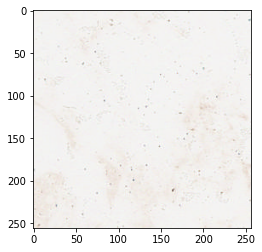

In [12]:
brain = BrainDataSet(PATH_DIR)
brain.visualize(32)
brain.__getitem__(90000)

# Define Parameters
SIZE = brain.__len__()
VAL_RATIO = 0.05
VAL_SIZE = int(SIZE * VAL_RATIO)
TRAIN_SIZE = SIZE - VAL_SIZE
print(SIZE, TRAIN_SIZE, VAL_SIZE) 

In [13]:
NORM_PATH = '/BrainSeg/normalization.npy'
norm = np.load(NORM_PATH,allow_pickle=True).item()
print(norm)

{'mean': array([0.77906426, 0.74919518, 0.77529276]), 'std': array([0.13986633, 0.15931302, 0.17665639])}


In [14]:
def Load_Train_Val(PATH_DIR, norm, TRAIN_SIZE, VAL_SIZE, batch_size):
    # PATH = '/content/drive/My Drive/brain training/training_dataset'
    Train_Dataset = BrainDataSet(PATH_DIR,
    #                             train = True,
                              transform = transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.RandomVerticalFlip(),
                              transforms.RandomRotation(180),
                              transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
                              transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
                              transforms.ToTensor(),
                              transforms.Normalize(norm['mean'], norm['std'])
                              ]))
    #   train_data, val_data = torch.utils.data.dataset.random_split(Train_Dataset, (TRAIN_SIZE, VAL_SIZE))
    train_data, val_data = torch.utils.data.random_split(Train_Dataset, (TRAIN_SIZE, VAL_SIZE))
    print('The size of train data: ', len(train_data))
    print('The size of val data: ', len(val_data))
    #   print(len(train_data))
    train_loader = torch.utils.data.DataLoader(train_data,
                                             batch_size = batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_data,
                                             batch_size = batch_size, shuffle=True)
    return train_loader, val_loader

In [15]:
train_loader, val_loader = Load_Train_Val(PATH_DIR, norm, TRAIN_SIZE, VAL_SIZE, batch_size = 16)
print(train_loader)
print(val_loader)

The size of train data:  967731
The size of val data:  50933


In [16]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [17]:
!nvidia-smi

Fri Aug  7 13:53:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:65:00.0 Off |                  N/A |
| 29%   52C    P2   101W / 250W |   1712MiB / 12190MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [18]:
def resnet_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number):
  
    for epoch in range(num_epochs):
        start = time.time()
        running_loss = 0.0
        for i, data in enumerate(train_loader,0):
            inputs = data['image']
            labels = data['label']
            inputs, labels = Variable(inputs), Variable(labels)
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()

            outputs = model(inputs)
#             print(outputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 800 == 799:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                running_loss = 0.0
        end = time.time()
        print("Train Time:", end-start)
        print("Traing finished", epoch+1, "epochs")

    #     MODEL_NAME_1 = 'ResNet18_' + str(number) + '.pkl'
        MODEL_PATH_1 = PATH + '/' + 'ResNet18_' + str(number) + '.pkl'
    #     MODEL_NAME_2 = 'ResNet18_params_' + str(number) + '.pkl'
    #     MODEL_PATH_2 = PATH + '/' + 'ResNet18_params_' + str(number) + '.pkl'
        #     torch.save(model, MODEL_NAME_1)
        torch.save(model, MODEL_PATH_1)
        #     torch.save(model.state_dict(), MODEL_NAME_2)
    #     torch.save(model.state_dict(), MODEL_PATH_2)
        number = number + 1



        correct = 0
        total = 0
        val_loss = 0.0
        window = 200
        start = time.time()
        for i_val, data_val in enumerate(val_loader,0):
            img_val = data_val['image']
            label_val = data_val['label']
            img_val, label_val = Variable(img_val), Variable(label_val)
            img_val = img_val.cuda()
            label_val = label_val.cuda()

            predict = model(img_val)
            loss_val = loss_func(predict, label_val)
            val_loss += loss_val.item()
            _, predict = torch.max(predict.data, 1)
            total += label_val.size(0)
            correct += (label_val == predict).sum().item()
            if i_val % window == window-1:    # print every 2000 mini-batches
                print('[%5d] val_loss: %.3f' %
                        (i_val + 1, val_loss / window))
                val_loss = 0.0
        print('Accuracy = %.6f' % (100 * correct / total))
        end = time.time()
        print('val_time', end - start)

    print('Finished Training')
    torch.save(model, MODEL_PATH_1)
#   torch.save(model.state_dict(), MODEL)

In [29]:
# model = torch.load('/BrainSeg/Checkpoints/ResNet18_18.pkl')
import torchvision.models as models
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,3)
model = model.cuda()

In [ ]:
model = torch.load('/BrainSeg/Checkpoints/new_LF/ResNet18_0.pkl')
# import torchvision.models as models
# model = models.resnet18()
model = model.cuda()
weight = torch.tensor([0.2,0.6,0.2]).cuda()
loss_func = nn.CrossEntropyLoss(weight=weight)
lr_scheduler = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr_scheduler)
num_epochs = 2
PATH = '/BrainSeg/Checkpoints/new_LF/'
if not os.path.exists(PATH):
    os.makedirs(PATH)
number = 1
resnet_train(model, loss_func, optimizer, lr_scheduler, num_epochs, PATH, train_loader, val_loader, number)

[1,   800] loss: 0.689
[1,  1600] loss: 0.610
[1,  2400] loss: 0.675
[1,  3200] loss: 0.614
[1,  4000] loss: 0.629
[1,  4800] loss: 0.611
[1,  5600] loss: 0.586
[1,  6400] loss: 0.598
[1,  7200] loss: 0.654
[1,  8000] loss: 0.630
[1,  8800] loss: 0.632
[1,  9600] loss: 0.626
[1, 10400] loss: 0.650
[1, 11200] loss: 0.639
[1, 12000] loss: 0.629
[1, 12800] loss: 0.592
[1, 13600] loss: 0.648
[1, 14400] loss: 0.619
[1, 15200] loss: 0.625
[1, 16000] loss: 0.607
